Copyright &copy; 2013 Ondrej Martinsky, All rights reserved

[www.quantandfinancial.com](http://www.quantandfinancial.com)
# Portfolio Optimization and Black-Litterman

#### Mathematical symbols used in this notebook

| Python symbol | Math Symbol | Comment
| -- | -- | --
| rf | $r$ | risk free rate
| lmb | $\lambda$ | risk aversion coefficient
| C | $C$ | Assets covariance matrix
| V | $V$ | Assets variances (diagonal in covariance matrix)
| W | $W$ | Assets weights
| R | $R$ | Assets returns
| mean | $\mu$ | Portfolio historical return
| var | $\sigma$ | Portfolio historical variance
| Pi | $\Pi$ | Portfolio equilibrium excess returns
| tau | $\tau$ | Scaling factor for Black-litterman

In [1]:
%pylab
%matplotlib inline
pylab.rcParams['figure.figsize'] = (10, 6)
import scipy.optimize
from pandas import *

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


## Few helper functions

In [2]:
# Calculates portfolio mean return
def port_mean(W, R):
    return sum(R * W)

# Calculates portfolio variance of returns
def port_var(W, C):
    return dot(dot(W, C), W)

# Combination of the two functions above - mean and variance of returns calculation
def port_mean_var(W, R, C):
    return port_mean(W, R), port_var(W, C)

In [3]:
# Given risk-free rate, assets returns and covariances, this function calculates
# mean-variance frontier and returns its [x,y] points in two arrays
def solve_frontier(R, C, rf):
    def fitness(W, R, C, r):
        # For given level of return r, find weights which minimizes portfolio variance.
        mean, var = port_mean_var(W, R, C)
        penalty = 100 * abs(
            mean - r)  # Big penalty for not meeting stated portfolio return effectively serves as optimization constraint
        return var + penalty

    frontier_mean, frontier_var, frontier_weights = [], [], []
    n = len(R)  # Number of assets in the portfolio
    for r in linspace(min(R), max(R), num=20):  # Iterate through the range of returns on Y axis
        W = ones([n]) / n  # start optimization with equal weights
        b_ = [(0, 1) for i in range(n)]
        c_ = ({'type': 'eq', 'fun': lambda W: sum(W) - 1.})
        optimized = scipy.optimize.minimize(fitness, W, (R, C, r), method='SLSQP', constraints=c_, bounds=b_)
        if not optimized.success:
            raise BaseException(optimized.message)
        # add point to the efficient frontier [x,y] = [optimized.x, r]
        frontier_mean.append(r)
        frontier_var.append(port_var(optimized.x, C))
        frontier_weights.append(optimized.x)
    return array(frontier_mean), array(frontier_var), frontier_weights

In [6]:
# Given risk-free rate, assets returns and covariances, this function calculates
# weights of tangency portfolio with respect to sharpe ratio maximization
def solve_weights(R, C, rf):
    def fitness(W, R, C, rf):
        mean, var = port_mean_var(W, R, C)  # calculate mean/variance of the portfolio
        util = (mean - rf) / sqrt(var)  # utility = Sharpe ratio
        return 1 / util  # maximize the utility, minimize its inverse value
    n = len(R)
    W = ones([n]) / n  # start optimization with equal weights
    b_ = [(0., 1.) for i in range(n)]  # weights for boundaries between 0%..100%. No leverage, no shorting
    c_ = ({'type': 'eq', 'fun': lambda W: sum(W) - 1.})  # Sum of weights must be 100%
    optimized = scipy.optimize.minimize(fitness, W, (R, C, rf), method='SLSQP', constraints=c_, bounds=b_)
    if not optimized.success: raise BaseException(optimized.message)
    return optimized.x

In [7]:
class Result:
    def __init__(self, W, tan_mean, tan_var, front_mean, front_var, front_weights):
        self.W=W
        self.tan_mean=tan_mean
        self.tan_var=tan_var
        self.front_mean=front_mean
        self.front_var=front_var
        self.front_weights=front_weights
        
def optimize_frontier(R, C, rf):
    W = solve_weights(R, C, rf)
    tan_mean, tan_var = port_mean_var(W, R, C)  # calculate tangency portfolio
    front_mean, front_var, front_weights = solve_frontier(R, C, rf)  # calculate efficient frontier
    # Weights, Tangency portfolio asset means and variances, Efficient frontier means and variances
    return Result(W, tan_mean, tan_var, front_mean, front_var, front_weights)

def display_assets(names, R, C, color='black'):
    scatter([C[i, i] ** .5 for i in range(n)], R, marker='x', color=color), grid(True)  # draw assets
    for i in range(n): 
        text(C[i, i] ** .5, R[i], '  %s' % names[i], verticalalignment='center', color=color) # draw labels

def display_frontier(result: Result, label=None, color='black'):
    from collections import defaultdict
    from IPython.core.display import HTML
    text(result.tan_var ** .5, result.tan_mean, '   tangent', verticalalignment='center', color=color)
    scatter(result.tan_var ** .5, result.tan_mean, marker='o', color=color), grid(True)
    plot(list(result.front_var ** .5), list(result.front_mean), label=label, color=color), grid(True)  # draw efficient frontier
    
    table = defaultdict(list)
    for mean, var, weights in zip(result.front_mean, result.front_var, result.front_weights):
        table['Mean'].append(mean)
        table['Variance'].append(var)
        for name, weight in zip(names, weights):
            table[name].append(weight)
    display(HTML(f'<b>Efficient frontier portfolios ({label})</b>'), DataFrame(table))

## Load historical prices

In [8]:
# Function loads historical stock prices of nine major S&P companies and returns them together
# with their market capitalizations, as of 2013-07-01
def load_data():
    symbols = ['XOM', 'AAPL', 'MSFT', 'JNJ', 'GE', 'GOOG', 'CVX', 'PG', 'WFC']
    cap = {'XOM': 403.02e9, 'AAPL': 392.90e9, 'MSFT': 283.60e9, 'JNJ': 243.17e9, 'GE': 236.79e9,
           'GOOG': 292.72e9, 'CVX': 231.03e9, 'PG': 214.99e9, 'WFC': 218.79e9}
    n = len(symbols)
    prices_out, caps_out = [], []
    for s in symbols:
        dataframe = pandas.read_csv('data/%s.csv' % s, index_col=None, parse_dates=['date'])
        prices = list(dataframe['close'])[-500:] # trailing window 500 days
        prices_out.append(prices)
        caps_out.append(cap[s])
    return symbols, prices_out, caps_out

names, prices, caps = load_data()
n = len(names)

## Estimate assets historical return and covariances

In [9]:
# Function takes historical stock prices together with market capitalizations and
# calculates weights, historical returns and historical covariances
def assets_historical_returns_and_covariances(prices):
    prices = matrix(prices)  # create numpy matrix from prices
    # create matrix of historical returns
    rows, cols = prices.shape
    returns = empty([rows, cols - 1])
    for r in range(rows):
        for c in range(cols - 1):
            p0, p1 = prices[r, c], prices[r, c + 1]
            returns[r, c] = (p1 / p0) - 1
    # calculate returns
    expreturns = array([])
    for r in range(rows):
        expreturns = append(expreturns, numpy.mean(returns[r]))
    # calculate covariances
    covars = cov(returns)
    expreturns = (1 + expreturns) ** 250 - 1  # Annualize returns
    covars = covars * 250  # Annualize covariances
    return expreturns, covars

W = array(caps) / sum(caps) # calculate market weights from capitalizations
R, C = assets_historical_returns_and_covariances(prices)
rf = .015  # Risk-free rate

##### Asset returns and weights

In [10]:
display(pandas.DataFrame({'Return': R, 'Weight (based on market cap)': W}, index=names).T)

,XOM,AAPL,MSFT,JNJ,GE,GOOG,CVX,PG,WFC
Return,0.072993,0.129536,0.172047,0.143764,0.140385,0.331958,0.092131,0.112222,0.268935
Weight (based on market cap),0.160119,0.156098,0.112673,0.096611,0.094076,0.116297,0.091787,0.085415,0.086925


##### Asset covariances

In [11]:
display(pandas.DataFrame(C, columns=names, index=names))

,XOM,AAPL,MSFT,JNJ,GE,GOOG,CVX,PG,WFC
XOM,0.039015,0.022296,0.027982,0.019595,0.036647,0.026728,0.038245,0.018216,0.042972
AAPL,0.022296,0.091844,0.024599,0.011578,0.027814,0.033249,0.028240,0.011532,0.036756
MSFT,0.027982,0.024599,0.051014,0.016842,0.032649,0.026231,0.030815,0.013724,0.040321
JNJ,0.019595,0.011578,0.016842,0.019456,0.021048,0.015547,0.021005,0.013196,0.026861
GE,0.036647,0.027814,0.032649,0.021048,0.059233,0.031083,0.040677,0.019377,0.053928
GOOG,0.026728,0.033249,0.026231,0.015547,0.031083,0.066899,0.030258,0.015123,0.039019
CVX,0.038245,0.028240,0.030815,0.021005,0.040677,0.030258,0.050857,0.019587,0.048326
PG,0.018216,0.011532,0.013724,0.013196,0.019377,0.015123,0.019587,0.025152,0.022479
WFC,0.042972,0.036756,0.040321,0.026861,0.053928,0.039019,0.048326,0.022479,0.089826


## Mean-Variance Optimization (based on historical returns)

,Mean,Variance,XOM,AAPL,MSFT,JNJ,GE,GOOG,CVX,PG,WFC
0,0.072993,0.039015,1.000000e+00,6.605827e-13,0.000000e+00,3.141376e-13,3.582690e-13,0.000000e+00,1.133815e-12,8.088530e-13,0.000000e+00
1,0.086623,0.027910,6.525565e-01,4.218062e-18,5.706074e-18,3.433351e-18,1.065141e-17,1.927088e-18,1.545199e-18,3.474435e-01,1.066650e-17
2,0.100252,0.022646,3.905902e-01,3.103374e-02,4.266288e-18,8.927138e-02,6.783755e-18,1.230066e-17,1.004120e-17,4.891047e-01,1.761433e-18
3,0.113882,0.019316,2.308188e-01,4.236281e-02,1.108969e-19,3.164565e-01,0.000000e+00,0.000000e+00,4.355409e-18,4.103618e-01,4.758012e-18
4,0.127512,0.017275,3.965620e-02,6.477813e-02,1.108916e-17,4.985158e-01,1.896963e-18,2.120003e-18,0.000000e+00,3.970499e-01,0.000000e+00
5,0.141142,0.016978,6.475150e-18,5.848534e-02,4.510014e-03,5.812870e-01,0.000000e+00,4.233439e-02,1.453435e-20,3.133833e-01,2.352862e-18
6,0.154772,0.017387,1.554093e-18,3.475580e-02,1.683372e-02,5.931648e-01,0.000000e+00,1.011716e-01,1.565852e-18,2.540741e-01,0.000000e+00
7,0.168401,0.018219,0.000000e+00,1.770226e-02,1.377155e-02,5.849027e-01,4.862524e-18,1.665627e-01,1.122939e-17,2.170608e-01,8.391482e-18
8,0.182031,0.019465,8.080200e-20,7.465324e-18,1.244240e-02,5.867022e-01,8.786701e-18,2.300888e-01,1.187439e-17,1.707667e-01,1.422955e-17
9,0.195661,0.021152,1.410919e-23,0.000000e+00,7.591093e-03,5.726089e-01,3.349527e-17,2.954603e-01,2.259157e-17,1.243397e-01,1.686823e-24


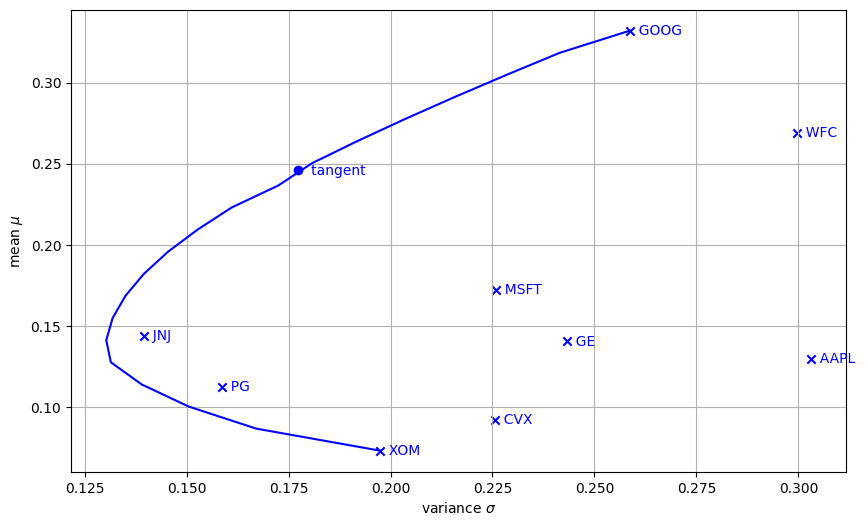

,XOM,AAPL,MSFT,JNJ,GE,GOOG,CVX,PG,WFC
Weight,7.856852e-17,4.734715e-18,0.0,0.450921,0.0,0.528356,0.0,0.0,0.020723


In [12]:
res1 = optimize_frontier(R, C, rf)

display_assets(names, R, C, color='blue')
display_frontier(res1, color='blue')
xlabel('variance $\sigma$'), ylabel('mean $\mu$'), show()
display(pandas.DataFrame({'Weight': res1.W}, index=names).T)

## Black-litterman reverse optimization

In [13]:
# Calculate portfolio historical return and variance
mean, var = port_mean_var(W, R, C)

lmb = (mean - rf) / var  # Calculate risk aversion
Pi = dot(dot(lmb, C), W)  # Calculate equilibrium excess returns

##### Mean-variance Optimization (based on equilibrium returns)

,Mean,Variance,XOM,AAPL,MSFT,JNJ,GE,GOOG,CVX,PG,WFC
0,0.072993,0.039015,1.000000e+00,6.605827e-13,0.000000e+00,3.141376e-13,3.582690e-13,0.000000e+00,1.133815e-12,8.088530e-13,0.000000e+00
1,0.086623,0.027910,6.525565e-01,4.218062e-18,5.706074e-18,3.433351e-18,1.065141e-17,1.927088e-18,1.545199e-18,3.474435e-01,1.066650e-17
2,0.100252,0.022646,3.905902e-01,3.103374e-02,4.266288e-18,8.927138e-02,6.783755e-18,1.230066e-17,1.004120e-17,4.891047e-01,1.761433e-18
3,0.113882,0.019316,2.308188e-01,4.236281e-02,1.108969e-19,3.164565e-01,0.000000e+00,0.000000e+00,4.355409e-18,4.103618e-01,4.758012e-18
4,0.127512,0.017275,3.965620e-02,6.477813e-02,1.108916e-17,4.985158e-01,1.896963e-18,2.120003e-18,0.000000e+00,3.970499e-01,0.000000e+00
5,0.141142,0.016978,6.475150e-18,5.848534e-02,4.510014e-03,5.812870e-01,0.000000e+00,4.233439e-02,1.453435e-20,3.133833e-01,2.352862e-18
6,0.154772,0.017387,1.554093e-18,3.475580e-02,1.683372e-02,5.931648e-01,0.000000e+00,1.011716e-01,1.565852e-18,2.540741e-01,0.000000e+00
7,0.168401,0.018219,0.000000e+00,1.770226e-02,1.377155e-02,5.849027e-01,4.862524e-18,1.665627e-01,1.122939e-17,2.170608e-01,8.391482e-18
8,0.182031,0.019465,8.080200e-20,7.465324e-18,1.244240e-02,5.867022e-01,8.786701e-18,2.300888e-01,1.187439e-17,1.707667e-01,1.422955e-17
9,0.195661,0.021152,1.410919e-23,0.000000e+00,7.591093e-03,5.726089e-01,3.349527e-17,2.954603e-01,2.259157e-17,1.243397e-01,1.686823e-24


,Mean,Variance,XOM,AAPL,MSFT,JNJ,GE,GOOG,CVX,PG,WFC
0,0.094449,0.025152,2.672748e-13,3.572319e-13,2.435565e-13,0.000000e+00,3.581387e-13,2.983883e-13,3.455312e-13,1.000000e+00,5.179457e-13
1,0.100962,0.016955,0.000000e+00,4.707574e-02,4.702165e-18,6.207401e-01,0.000000e+00,2.604992e-18,0.000000e+00,3.321842e-01,6.180660e-19
2,0.107475,0.017038,1.203237e-17,6.832140e-02,6.285275e-02,5.477271e-01,7.816419e-19,2.011701e-02,1.132728e-22,3.009817e-01,0.000000e+00
3,0.113988,0.017640,3.629467e-19,1.003799e-01,8.554589e-02,4.902690e-01,4.801612e-19,5.916964e-02,2.397363e-19,2.646355e-01,9.073667e-20
4,0.120502,0.018727,5.055196e-02,1.140558e-01,9.700561e-02,4.272378e-01,8.932504e-03,7.493824e-02,2.890739e-05,2.272492e-01,3.459933e-14
5,0.127015,0.020136,9.597881e-02,1.242659e-01,1.050317e-01,3.621044e-01,3.346330e-02,8.221222e-02,1.150837e-03,1.957929e-01,4.049333e-21
6,0.133528,0.021847,1.101331e-01,1.328656e-01,1.105985e-01,3.009384e-01,5.354278e-02,9.163214e-02,2.598859e-02,1.700190e-01,4.281912e-03
7,0.140042,0.023824,1.231671e-01,1.397297e-01,1.108375e-01,2.488346e-01,6.945714e-02,9.589285e-02,4.864063e-02,1.437902e-01,1.965022e-02
8,0.146555,0.026058,1.210757e-01,1.410799e-01,1.214485e-01,1.795371e-01,7.945523e-02,1.052581e-01,7.704990e-02,1.356069e-01,3.948861e-02
9,0.153068,0.028537,1.097746e-01,1.518764e-01,1.123430e-01,1.269889e-01,9.027044e-02,1.138527e-01,9.615948e-02,1.268776e-01,7.185687e-02


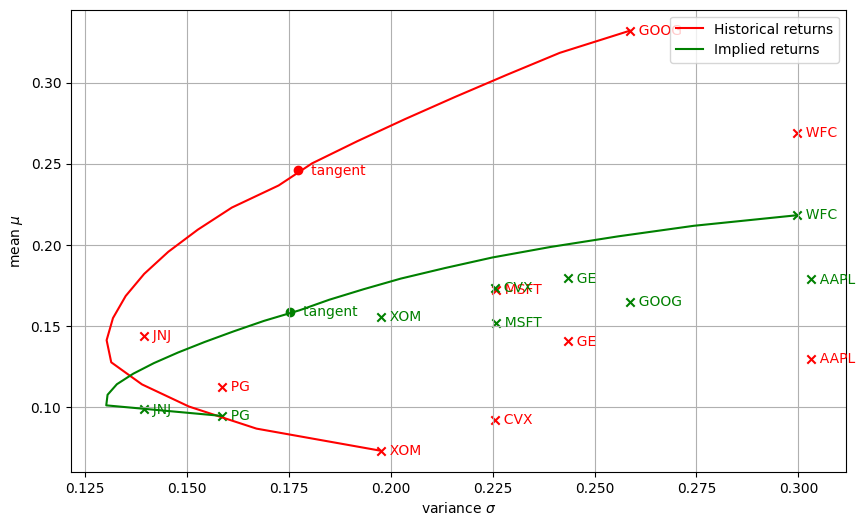

,XOM,AAPL,MSFT,JNJ,GE,GOOG,CVX,PG,WFC
Weight,0.160429,0.15617,0.112453,0.097424,0.093807,0.116209,0.091813,0.084692,0.087002


In [14]:
res2 = optimize_frontier(Pi+rf, C, rf)

display_assets(names, R, C, color='red')
display_frontier(res1, label='Historical returns', color='red')
display_assets(names, Pi+rf, C, color='green')
display_frontier(res2, label='Implied returns', color='green')
xlabel('variance $\sigma$'), ylabel('mean $\mu$'), legend(), show()
display(pandas.DataFrame({'Weight': res2.W}, index=names).T)

##### Determine views to the equilibrium returns and prepare views (Q) and link (P) matrices

In [15]:
def create_views_and_link_matrix(names, views):
    r, c = len(views), len(names)
    Q = [views[i][3] for i in range(r)]  # view matrix
    P = zeros([r, c])
    nameToIndex = dict()
    for i, n in enumerate(names):
        nameToIndex[n] = i
    for i, v in enumerate(views):
        name1, name2 = views[i][0], views[i][2]
        P[i, nameToIndex[name1]] = +1 if views[i][1] == '>' else -1
        P[i, nameToIndex[name2]] = -1 if views[i][1] == '>' else +1
    return array(Q), P

views = [('MSFT', '>', 'GE', 0.02),
         ('AAPL', '<', 'JNJ', 0.02)]

Q, P = create_views_and_link_matrix(names, views)
print('Views Matrix')
display(DataFrame({'Views':Q}))
print('Link Matrix')
display(DataFrame(P))

Views Matrix


,Views
0,0.02
1,0.02


Link Matrix


,0,1,2,3,4,5,6,7,8
0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0
1,0.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


##### Optimization based on Equilibrium returns with adjusted views

,Mean,Variance,XOM,AAPL,MSFT,JNJ,GE,GOOG,CVX,PG,WFC
0,0.094449,0.025152,2.672748e-13,3.572319e-13,2.435565e-13,0.000000e+00,3.581387e-13,2.983883e-13,3.455312e-13,1.000000e+00,5.179457e-13
1,0.100962,0.016955,0.000000e+00,4.707574e-02,4.702165e-18,6.207401e-01,0.000000e+00,2.604992e-18,0.000000e+00,3.321842e-01,6.180660e-19
2,0.107475,0.017038,1.203237e-17,6.832140e-02,6.285275e-02,5.477271e-01,7.816419e-19,2.011701e-02,1.132728e-22,3.009817e-01,0.000000e+00
3,0.113988,0.017640,3.629467e-19,1.003799e-01,8.554589e-02,4.902690e-01,4.801612e-19,5.916964e-02,2.397363e-19,2.646355e-01,9.073667e-20
4,0.120502,0.018727,5.055196e-02,1.140558e-01,9.700561e-02,4.272378e-01,8.932504e-03,7.493824e-02,2.890739e-05,2.272492e-01,3.459933e-14
5,0.127015,0.020136,9.597881e-02,1.242659e-01,1.050317e-01,3.621044e-01,3.346330e-02,8.221222e-02,1.150837e-03,1.957929e-01,4.049333e-21
6,0.133528,0.021847,1.101331e-01,1.328656e-01,1.105985e-01,3.009384e-01,5.354278e-02,9.163214e-02,2.598859e-02,1.700190e-01,4.281912e-03
7,0.140042,0.023824,1.231671e-01,1.397297e-01,1.108375e-01,2.488346e-01,6.945714e-02,9.589285e-02,4.864063e-02,1.437902e-01,1.965022e-02
8,0.146555,0.026058,1.210757e-01,1.410799e-01,1.214485e-01,1.795371e-01,7.945523e-02,1.052581e-01,7.704990e-02,1.356069e-01,3.948861e-02
9,0.153068,0.028537,1.097746e-01,1.518764e-01,1.123430e-01,1.269889e-01,9.027044e-02,1.138527e-01,9.615948e-02,1.268776e-01,7.185687e-02


,Mean,Variance,XOM,AAPL,MSFT,JNJ,GE,GOOG,CVX,PG,WFC
0,0.094449,0.025152,2.672748e-13,3.572319e-13,2.435565e-13,0.000000e+00,3.581387e-13,2.983883e-13,3.455312e-13,1.000000e+00,5.179457e-13
1,0.100962,0.016955,0.000000e+00,4.707574e-02,4.702165e-18,6.207401e-01,0.000000e+00,2.604992e-18,0.000000e+00,3.321842e-01,6.180660e-19
2,0.107475,0.017038,1.203237e-17,6.832140e-02,6.285275e-02,5.477271e-01,7.816419e-19,2.011701e-02,1.132728e-22,3.009817e-01,0.000000e+00
3,0.113988,0.017640,3.629467e-19,1.003799e-01,8.554589e-02,4.902690e-01,4.801612e-19,5.916964e-02,2.397363e-19,2.646355e-01,9.073667e-20
4,0.120502,0.018727,5.055196e-02,1.140558e-01,9.700561e-02,4.272378e-01,8.932504e-03,7.493824e-02,2.890739e-05,2.272492e-01,3.459933e-14
5,0.127015,0.020136,9.597881e-02,1.242659e-01,1.050317e-01,3.621044e-01,3.346330e-02,8.221222e-02,1.150837e-03,1.957929e-01,4.049333e-21
6,0.133528,0.021847,1.101331e-01,1.328656e-01,1.105985e-01,3.009384e-01,5.354278e-02,9.163214e-02,2.598859e-02,1.700190e-01,4.281912e-03
7,0.140042,0.023824,1.231671e-01,1.397297e-01,1.108375e-01,2.488346e-01,6.945714e-02,9.589285e-02,4.864063e-02,1.437902e-01,1.965022e-02
8,0.146555,0.026058,1.210757e-01,1.410799e-01,1.214485e-01,1.795371e-01,7.945523e-02,1.052581e-01,7.704990e-02,1.356069e-01,3.948861e-02
9,0.153068,0.028537,1.097746e-01,1.518764e-01,1.123430e-01,1.269889e-01,9.027044e-02,1.138527e-01,9.615948e-02,1.268776e-01,7.185687e-02


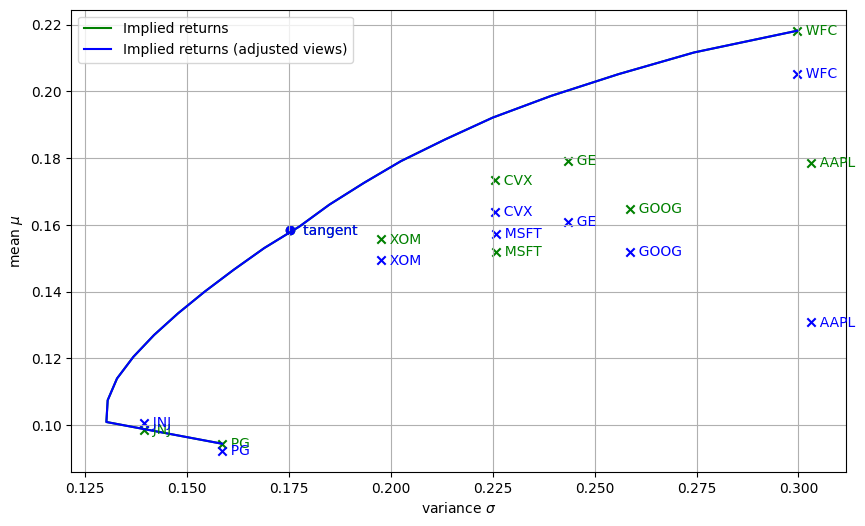

,XOM,AAPL,MSFT,JNJ,GE,GOOG,CVX,PG,WFC
Weight,0.160429,0.15617,0.112453,0.097424,0.093807,0.116209,0.091813,0.084692,0.087002


In [16]:
tau = .025  # scaling factor

# Calculate omega - uncertainty matrix about views
omega = dot(dot(dot(tau, P), C), transpose(P))  # 0.025 * P * C * transpose(P)
# Calculate equilibrium excess returns with views incorporated
sub_a = inv(dot(tau, C))
sub_b = dot(dot(transpose(P), inv(omega)), P)
sub_c = dot(inv(dot(tau, C)), Pi)
sub_d = dot(dot(transpose(P), inv(omega)), Q)
Pi_adj = dot(inv(sub_a + sub_b), (sub_c + sub_d))

res3 = optimize_frontier(Pi + rf, C, rf)

display_assets(names, Pi+rf, C, color='green')
display_frontier(res2, label='Implied returns', color='green')
display_assets(names, Pi_adj+rf, C, color='blue')
display_frontier(res3, label='Implied returns (adjusted views)', color='blue')
xlabel('variance $\sigma$'), ylabel('mean $\mu$'), legend(), show()
display(pandas.DataFrame({'Weight': res2.W}, index=names).T)